In [ ]:
import kagglehub
import shutil
import os

destination_path = "/content/sample_data"

# Downloading the dataset
path = kagglehub.dataset_download("lakshaytyagi01/fruit-detection")
os.makedirs(destination_path, exist_ok=True)

# Moving the downloaded files to the destination path
for file_name in os.listdir(path):
    shutil.move(os.path.join(path, file_name), destination_path)

print("Dataset files moved to:", destination_path)


100%|██████████| 501M/501M [00:10<00:00, 52.2MB/s]

Extracting files...


Dataset files moved to: /content/sample_data


In [ ]:
import os
import shutil
import random

source_path = "/content/sample_data/Fruits-detection"
destination_path = "/content/sample_data/newdataset"

# Categories and their labels
categories = {
    0: "Apple",
    1: "Banana",
    2: "Grapes",
    3: "Orange",
    5: "Watermelon"
}

images_per_category = 100

images_dest_path = os.path.join(destination_path, "images")
labels_dest_path = os.path.join(destination_path, "labels")
os.makedirs(images_dest_path, exist_ok=True)
os.makedirs(labels_dest_path, exist_ok=True)

for category_id, category_name in categories.items():
    all_images = []

    for split in ["train", "valid", "test"]:
        label_path = os.path.join(source_path, split, "labels")
        image_path = os.path.join(source_path, split, "images")

        if not os.path.exists(label_path):
            print(f"Label path not found: {label_path}")
            continue

        label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

        for label_file in label_files:
            label_file_path = os.path.join(label_path, label_file)
            with open(label_file_path, "r") as file:
                lines = file.readlines()
                for line in lines:
                    if line.startswith(str(category_id)):
                        image_file = label_file.replace(".txt", ".jpg")
                        all_images.append((os.path.join(image_path, image_file), label_file_path))
                        break

    selected_images = random.sample(all_images, min(images_per_category, len(all_images)))

    for idx, (img_file, lbl_file) in enumerate(selected_images):
        new_image_name = f"{category_name}_image{idx}.jpg"
        new_label_name = f"{category_name}_image{idx}.txt"

        shutil.copy(img_file, os.path.join(images_dest_path, new_image_name))

        new_label_path = os.path.join(labels_dest_path, new_label_name)
        with open(lbl_file, "r") as file:
            lines = file.readlines()

        with open(new_label_path, "w") as new_label_file:
            for line in lines:
                if line.startswith(str(category_id)):
                    new_label_file.write(line)

print(f"New dataset created successfully at {destination_path}.")


New dataset created successfully at /content/sample_data/newdataset.


In [ ]:
import os
import shutil
import random


source_path = "/content/sample_data/newdataset"
destination_path = "/content/sample_data/split_dataset"

splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(destination_path, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(destination_path, split, "labels"), exist_ok=True)

# Ratio for splits for train, val and test
split_ratio = [0.7, 0.2, 0.1]

images_path = os.path.join(source_path, "images")
labels_path = os.path.join(source_path, "labels")

images = sorted(os.listdir(images_path))
labels = sorted(os.listdir(labels_path))

if len(images) != len(labels):
    raise ValueError("Number of images and labels do not match!")

data = list(zip(images, labels))
random.shuffle(data)

total_files = len(data)
train_count = int(total_files * split_ratio[0])
val_count = int(total_files * split_ratio[1])
test_count = total_files - train_count - val_count

# Splitting the data
train_data = data[:train_count]
val_data = data[train_count:train_count + val_count]
test_data = data[train_count + val_count:]

def copy_files(data_split, split_name):
    for image_file, label_file in data_split:
        src_image = os.path.join(images_path, image_file)
        dest_image = os.path.join(destination_path, split_name, "images", image_file)
        shutil.copy(src_image, dest_image)

        src_label = os.path.join(labels_path, label_file)
        dest_label = os.path.join(destination_path, split_name, "labels", label_file)
        shutil.copy(src_label, dest_label)

copy_files(train_data, "train")
copy_files(val_data, "val")
copy_files(test_data, "test")

print(f"Dataset split completed successfully! Split dataset is saved at {destination_path}.")


Dataset split completed successfully! Split dataset is saved at /content/sample_data/split_dataset.


In [ ]:
import cv2
import numpy as np
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

class AugmentationPipeline:
    def __init__(self):
        self.augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=30, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.3),
            A.Blur(blur_limit=3, p=0.2),
            A.Resize(height=416, width=416, p=1.0),
            ToTensorV2()
        ])

    def apply_augmentations(self, image):
        """Apply augmentations to the input image."""
        augmented = self.augmentations(image=image)
        return augmented["image"]

    def apply_to_batch(self, images):
        """Apply augmentations to a batch of images."""
        return [self.apply_augmentations(img) for img in images]


def load_image(image_path):
    """Load an image from a file path."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return image


# Saving augmented image
def save_image(image, path):
    """Save augmented image to the specified path."""
    cv2.imwrite(path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


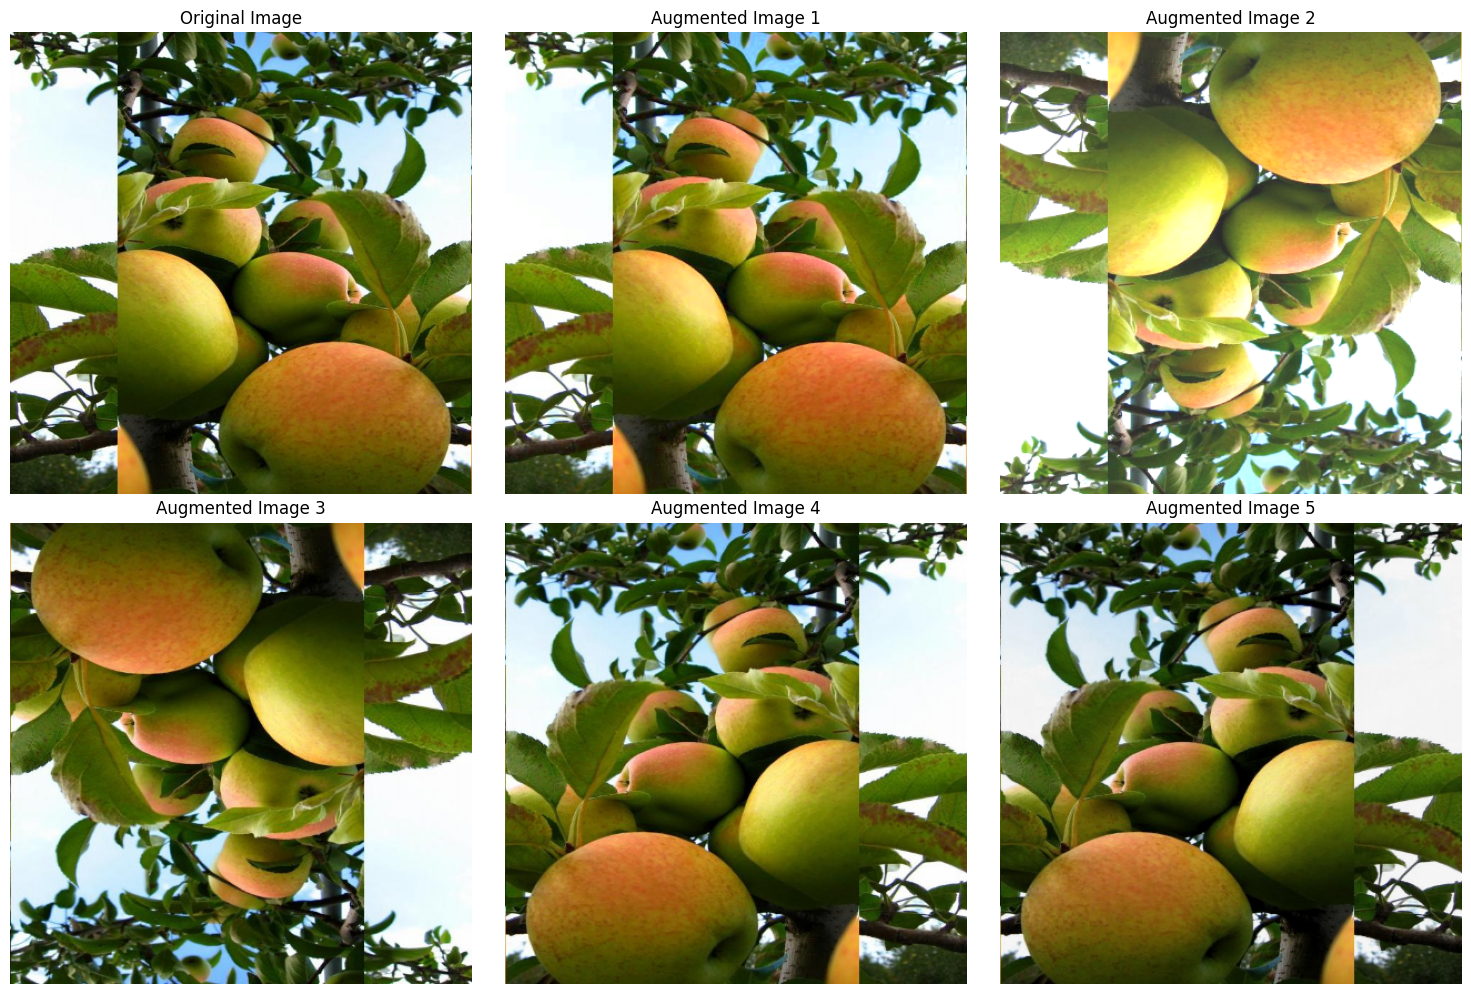

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

image_path = "/content/sample_data/split_dataset/train/images/Apple_image28.jpg"  # Replace with a valid image path
image = load_image(image_path)

# Initializing the augmentation pipeline
augmenter = AugmentationPipeline()

augmented_images = [augmenter.apply_augmentations(image) for _ in range(5)]

# Visualizing original and augmented images
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

for i, aug_img in enumerate(augmented_images, start=2):
    aug_img = np.transpose(aug_img, (1, 2, 0))
    plt.subplot(2, 3, i)
    plt.imshow(aug_img)
    plt.title(f"Augmented Image {i-1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class AugmentedDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        """
        Custom PyTorch Dataset with dynamic augmentation.

        Args:
        - images_dir: Path to the folder containing image files.
        - labels_dir: Path to the folder containing label files.
        - transform: AugmentationPipeline instance for applying augmentations.
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
        self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])
        self.transform = transform
        self.resize = transforms.Resize((416, 416))  # Ensure all images are resized

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        image = load_image(image_path)  # Load image as a numpy array (RGB)

        image = transforms.ToPILImage()(image)
        image = self.resize(image)
        image = np.array(image)

        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        with open(label_path, "r") as file:
            raw_labels = file.readlines()

        label = [list(map(float, line.strip().split())) for line in raw_labels]
        label = torch.tensor(label, dtype=torch.float32)  # Convert to tensor

        if self.transform:
            image = self.transform.apply_augmentations(image)

        if isinstance(image, np.ndarray):
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)

        return image, label


def collate_fn(batch):
    """
    Custom collate function to handle varying numbers of bounding boxes.
    Args:
    - batch: List of tuples (image, label).
    Returns:
    - images: Tensor of stacked images.
    - labels: List of tensors for labels (variable sizes).
    """
    images = torch.stack([item[0] for item in batch], dim=0)
    labels = [item[1] for item in batch]  # Labels remain as a list of tensors
    return images, labels


images_dir = "/content/sample_data/split_dataset/test/images"  # Update with your images path
labels_dir = "/content/sample_data/split_dataset/test/labels"  # Update with your labels path

augmenter = AugmentationPipeline()

train_dataset = AugmentedDataset(images_dir, labels_dir, transform=augmenter)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"Images shape: {images.shape}")
    print(f"Labels: {[label.shape for label in labels]}")  # Print shape of each label tensor


Batch 0:
Images shape: torch.Size([16, 3, 416, 416])
Labels: [torch.Size([2, 5]), torch.Size([1, 5]), torch.Size([4, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([7, 5]), torch.Size([1, 5]), torch.Size([2, 5]), torch.Size([5, 5]), torch.Size([1, 5]), torch.Size([2, 5]), torch.Size([3, 5]), torch.Size([7, 5]), torch.Size([2, 5]), torch.Size([4, 5])]
Batch 1:
Images shape: torch.Size([16, 3, 416, 416])
Labels: [torch.Size([5, 5]), torch.Size([1, 5]), torch.Size([2, 5]), torch.Size([2, 5]), torch.Size([1, 5]), torch.Size([3, 5]), torch.Size([1, 5]), torch.Size([11, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([2, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 5])]
Batch 2:
Images shape: torch.Size([16, 3, 416, 416])
Labels: [torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([3, 5]), torch.Size([5, 5]), torch.Size([2, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1

In [ ]:
import hashlib

name = "POOja4"

x = int(hashlib.sha256(name.encode('utf-8')).hexdigest(), 16) % 50

print(f"The hash value of the name '{name}' is: {x}")

The hash value of the name 'POOja4' is: 5


5)

In [ ]:
import os

repo_url = "https://github.com/WongKinYiu/yolov7.git"
repo_name = "yolov7"


current_dir = "/content/sample_data"
os.chdir(current_dir)

# Cloning the repository
clone_command = f"git clone {repo_url}"
os.system(clone_command)

repo_path = os.path.join(current_dir, repo_name)

if os.path.exists(repo_path):
    print(f"The repository was successfully cloned at: {repo_path}")
else:
    print("Failed to clone the repository. Please check the URL and try again.")


The repository was successfully cloned at: /content/sample_data/yolov7


In [ ]:
import sys
from pathlib import Path

# Adding the YOLOv7 directory to the system path
yolov7_path = Path("/content/sample_data/yolov7")  # Replace with your YOLOv7 root directory
sys.path.append(str(yolov7_path))


In [ ]:
import shutil

source_path = '/content/sample_data/split_dataset/val'
destination_path = '/content/sample_data/yolov7/Dataset/val'

shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print(f"Contents of '{source_path}' successfully copied to '{destination_path}'.")


Contents of '/content/sample_data/split_dataset/val' successfully copied to '/content/sample_data/yolov7/Dataset/val'.


In [ ]:
import sys
from pathlib import Path
import os
import torch
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from utils.general import non_max_suppression, scale_coords
from utils.datasets import letterbox
from models.experimental import attempt_load

categories = ['Apple', 'Banana', 'Grape', 'Orange', 'Watermelon']

# Adding the YOLOv7 directory to the system path
yolov7_path = Path("/content/sample_data/yolov7")
sys.path.append(str(yolov7_path))

DATA_YAML = "/content/sample_data/yolov7/Dataset/data.yaml"
CONFIG = "/content/sample_data/yolov7/cfg/training/yolov7.yaml"
HYP = "/content/sample_data/yolov7/data/hyp.scratch.yaml"
PRETRAINED_WEIGHTS = "/content/sample_data/yolov7/yolov7.pt"
VAL_JSON = "/content/sample_data/yolov7/Dataset/annotations/instances_val.json"
VAL_IMAGES = "/content/sample_data/yolov7/Dataset/val/images"
NO_AUG_WEIGHTS = "/content/yolov7/runs/train_no_aug/weights/best1.pt"
WITH_AUG_WEIGHTS = "/content/yolov7/runs/train_with_aug/weights/best1.pt"

os.makedirs("/content/yolov7/runs/train_no_aug", exist_ok=True)
os.makedirs("/content/yolov7/runs/train_with_aug", exist_ok=True)

# Training function
def train_yolov7(data_yaml, cfg, weights, hyp, save_dir, epochs, batch_size, augmentation):
    os.makedirs(save_dir, exist_ok=True)
    print(f"{'Training with' if augmentation else 'Training without'} data augmentation...")
    command = f"""
    python train.py --data {data_yaml} --cfg {cfg} --weights {weights} --hyp {hyp} \
    --epochs {epochs} --batch-size {batch_size} --img-size 640 --project {save_dir} --name train
    """
    os.system(command)

# Training without augmentation
train_yolov7(DATA_YAML, CONFIG, PRETRAINED_WEIGHTS, HYP, "/content/yolov7/runs/train_no_aug", epochs=50, batch_size=16, augmentation=False)

# Training with augmentation
train_yolov7(DATA_YAML, CONFIG, PRETRAINED_WEIGHTS, HYP, "/content/yolov7/runs/train_with_aug", epochs=50, batch_size=16, augmentation=True)

def evaluate_model(weights_path, val_json, val_images_dir):
    print(f"Evaluating model: {weights_path}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = attempt_load(weights_path, map_location=device)  # Load model
    model.eval()

    coco_gt = COCO(val_json)
    coco_dt = []

    for img_id, img_info in coco_gt.imgs.items():
        img_path = os.path.join(val_images_dir, img_info["file_name"])
        img0 = cv2.imread(img_path)
        img = letterbox(img0, 640, stride=32, auto=True)[0]
        img = torch.from_numpy(img).to(device).float() / 255.0
        img = img.permute(2, 0, 1).unsqueeze(0)

        with torch.no_grad():
            pred = model(img)
            if isinstance(pred, tuple):
                pred = pred[0]
            pred = non_max_suppression(pred, conf_thres=0.001, iou_thres=0.6)[0]

        if pred is not None:
            for *xyxy, conf, cls in pred:
                coco_dt.append({
                    "image_id": img_id,
                    "category_id": int(cls) + 1,
                    "bbox": [float(xyxy[0]), float(xyxy[1]), float(xyxy[2] - xyxy[0]), float(xyxy[3] - xyxy[1])],
                    "score": float(conf),
                })

    coco_dt = coco_gt.loadRes(coco_dt)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

print("Evaluating model without augmentation...")
evaluate_model(NO_AUG_WEIGHTS, VAL_JSON, VAL_IMAGES)

print("Evaluating model with augmentation...")
evaluate_model(WITH_AUG_WEIGHTS, VAL_JSON, VAL_IMAGES)

def visualize_predictions(image_path, weights_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = attempt_load(weights_path, map_location=device)  # Load model correctly
    model.eval()

    img0 = cv2.imread(image_path)
    img = letterbox(img0, 640, stride=32, auto=True)[0]
    img = torch.from_numpy(img).to(device).float() / 255.0
    img = img.permute(2, 0, 1).unsqueeze(0)

    with torch.no_grad():
        pred = model(img)
        if isinstance(pred, tuple):
            pred = pred[0]
        pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45)[0]

    for *xyxy, conf, cls in pred:
        if int(cls) >= len(categories):
            print(f"Warning: Predicted class {int(cls)} is out of range for categories.")
            continue
        label = f"{categories[int(cls)]} {conf:.2f}"
        cv2.rectangle(img0, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
        cv2.putText(img0, label, (int(xyxy[0]), int(xyxy[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Visualizing predictions for a test image
TEST_IMAGE = "/content/sample_data/yolov7/Dataset/val/images/Apple_image33.jpg"  # Replace with a sample image
print("Visualizing predictions without augmentation:")
visualize_predictions(TEST_IMAGE, NO_AUG_WEIGHTS)

print("Visualizing predictions with augmentation:")
visualize_predictions(TEST_IMAGE, WITH_AUG_WEIGHTS)


Training without data augmentation...
Training with data augmentation...
Evaluating model without augmentation...
Evaluating model: /content/yolov7/runs/train_no_aug/weights/best1.pt
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (